# Text mining and Sentiment analysis of Sephora skincare reviews 
**Weronika Mądro (473193) and Yuliya Martyniuk (474075)**





## Introduction 


**Purpose of the project**

In this project we would like to investigate how consumers talk about beauty products and how this language relates to their ratings and satisfaction. The primary purpose is to apply text mining and NLP methods to customer-written reviews in order to identify dominant themes, sentiment patterns, and recurring concerns, and to assess whether textual features can help explain or predict star ratings across different brands, product types, and price segments. A secondary goal is to use this real-world dataset as a case study for comparing alternative NLP approaches to sentiment or rating prediction in a commercial context.


**Main assumptions**

This analysis is based on a few simple assumptions. 
1. It assumes that most customer reviews are honest and reflect real experiences with the products, so fake or unusual reviews do not change the overall picture. 
2. It assumes that the star rating is a good summary of how satisfied the customer is, and that the tone of the review text usually matches the number of stars. 
3. It assumes that this dataset gives a fairly accurate overview of Sephora’s skincare products and customers, without major gaps or biases caused by how the data was collected. 
4. It assumes that the review text contains enough clear and usable information for text analysis, and that the product information linked to each review has been recorded correctly.

## Loading libraries 

In [1]:
# !pip install textblob
# !pip install matplotx
# !pip install vaderSentiment
# !pip install emoji
import matplotx
import pandas as pd
import numpy as np
import os
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from textblob import TextBlob
import re
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import matplotx
import seaborn as sns
from wordcloud import WordCloud
import warnings
import emoji
import unicodedata
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [2]:
nltk_resources = ['punkt', 'punkt_tab', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 'maxent_ne_chunker', 'words']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}')
    except LookupError:
        nltk.download(resource)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ydmar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ydmar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ydmar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\ydmar\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ydmar\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Data 

The dataset consists of Sephora skincare products and customer reviews collected through web scraping in year 2025. The original author used a Python-based web scraper to extract data directly from Sephora's website, specifically targeting the JSON-LD structured data embedded in product pages to minimize parsing errors and ensure data reliability. This scraping approach captured two main components: product-level information (over 8,000 beauty products) and customer review data (approximately 1 million reviews from the skincare category). The dataset includes two primary CSV files: Product and Review datasets. 

The author conducted systematic data cleaning to produce an analysis-ready dataset suitable for text mining and NLP tasks. The cleaning workflow included several key steps, specifically for Product data cleaning:
1. Removed products without review information.
2. Preserved multi-label duplicates intentionally. Since the same product can belong to multiple marketing labels, the author retained one row per unique combination of name, brand, category, and label, allowing users to analyze products by label without losing membership information.
3. Fixed scraping inconsistencies that were corrected case-by-case by normalizing price, rating, and review count.
4. Dropped the "best rating" column because it contained only a single value (5.0) across all products. 

And for the Reviews data cleaning: 
1. Missing review titles (20.6% of reviews) were imputed with empty strings to maintain consistent text fields. Reviews missing the actual text field (0.12% of data) were dropped entirely. 
2. For products with variants (mini sizes or refills), the author aligned the "item_reviewed" field in reviews to match canonical product names in the product table, ensuring accurate joins.

Then, the two datasets were joined on product name and label, creating a unified table where each row represents one review with attached product metadata. Additionally, the author concatenated the review title and text into a single "full_review" field. The author is also applied sentiment scoring, however, our aim is to investigate the data by ourselves. So, we will drop these columns. 

The following columns now in the cleaned Product-Review dataset: 

**review_id** - Unique identifier assigned to each review;<br>
**date_published** - Date the review was posted;<br>
**rating_value** - Star rating given by the reviewer (1–5);<br>
**title** - Review title provided by the user (may be empty);<br>
**text** - Main body of the review; <br> 
**label** - Marketing category under which the product was scraped (Clean, Planet Aware, Vegan, Cruelty-Free, Luxury); <br>
**name** - Name of the skincare product as listed on Sephora; <br>
**brand** - Brand or manufacturer of the product; <br>
**category** - Sephora product category (e.g., Moisturizer, Cleanser); <br>
**description** - Short marketing or product description from the page; <br>
**price** - Listed retail price;<br>
**currency** - Currency the price is listed in;<br>
**review_count** - Total number of reviews for the product;<br>
**aggregate_rating** - Average star rating for the product (1–5);<br>
**full_review** - Merged title with text field;<br>
**sentiment** - produced sentiment by author;<br> 
**polarity_score** -  produced polarity by author;<br> 

For this text mining course project, we will use the author's cleaned dataset (combined_product_review_data.csv) as the starting point, which saves substantial preprocessing effort and ensures data quality.  
 
Before proceeding with text mining, we will conduct our own exploratory data analysis to verify data quality, check for any remaining inconsistencies, examine the distribution of ratings and review lengths, and understand the characteristics of the text corpus. We will document any additional preprocessing steps we perform (text normalization, stopword removal, tokenization) to ensure reproducibility and methodological rigor for the course project.

In [3]:
df = pd.read_csv("combined_product_review_data.csv")  
print(df.head(5))
print(df.shape)

   review_id date_published  rating_value                           title  \
0  351645103     2025-07-10           3.0  This lip balm is a miss for me   
1  349938731     2025-06-17           5.0                             NaN   
2  348900301     2025-06-08           5.0                             NaN   
3  347053222     2025-05-24           4.0               amazing… at times   
4  346825636     2025-05-21           3.0                       It’s okay   

                                                                                                  text  \
0  It’s much thinner than I thought it would be and the hydration doesn’t last very long. The flavo...   
1  Consistency is a great mix between a balm and an oil! My issue with a lot of the new “lip oil” p...   
2  As someone who never writes reviews, I HAD TO for this product! It is absolutely amazing. Moistu...   
3  i’m lucky enough to have tried multiple tubes of this product. there seems to be a difference in...   
4  It’s

In [4]:
# drop title and text, since full_review contains this information 
# drop sentiment and polarity since they were produced by author
df = df.drop(columns = ['title', 'text', 'sentiment', 'polarity_score'])

In [5]:
df.nunique()

review_id           18556
date_published       1501
rating_value            5
label                   5
name                 2011
brand                 171
category               85
description          1948
price                 315
currency                1
review_count          949
aggregate_rating     1754
full_review         18765
dtype: int64

We can see that we have 40,234 entries, but only 18765 unique reviews. It could be because the author saved multi-label reviews and kept entries by unique name, brand, category, and label, and, as a result, the same review could apper multiple times if the product belongs to multiple marketing categories (labels). Another assumption that some reviews, if they are short, just a simple words like "nice", "love it", "hate it", ect. Lets check our assumptions. 

In [6]:
# Lets check the distribution of the reviews 
dupl_counts = df.groupby('full_review').size().reset_index(name='count')
dupl_counts = dupl_counts[dupl_counts['count'] > 1].sort_values('count', ascending=False)

print(f"\nDistribution of duplicate reviews:")
print(dupl_counts['count'].value_counts().sort_index())
print("Why the same review appears multiple times")

# Pick a review that appears many times
sample_full_review = dupl_counts.iloc[0]['full_review']
sample_df = df[df['full_review'] == sample_full_review][['review_id', 'name', 'label', 'brand']]

print(f"\nReview ID: {sample_df['review_id'].iloc[0]}")
print(f"Review text (first 100 chars): {sample_full_review[:100]}...\n")
print(f"This review appears {len(sample_df)} times:\n")
print(sample_df.to_string(index=False))

# What labels does it have?
print(f"\n\nLabels for this review:")
for idx, row in sample_df.iterrows():
    print(f"  - {row['label']}")



Distribution of duplicate reviews:
count
2     5645
3     3554
4     1615
5      202
6      268
7       43
8      141
10      39
11       2
12       8
20       1
Name: count, dtype: int64
Why the same review appears multiple times

Review ID: 360988607
Review text (first 100 chars): This lotion is such a Beautiful scent. Ultra hydrating and leaves your skin with a beautiful glow. Y...

This review appears 20 times:

 review_id                                                                                                 name        label      brand
 360988607      Mini The Body Wash Eucalyptus - Nourishing Treatment Cleanse With Lipid-Rich Oils + Niacinamide        clean Nécessaire
 360988607           The Body Wash Eucalyptus - Nourishing Treatment Cleanse With Lipid-Rich Oils + Niacinamide        clean Nécessaire
 360989695            The Body Wash Santal – Therapeutic treatment Cleanse With Epsom Salt + Minerals With Pump        clean Nécessaire
 360988607 The Body Wash Eucalyptus

Yes, we proved our assumption that reviews were duplicated due to the different labels for one review. It is still usefull for our dataset EDA, however, for the text mining, sentiment analysis, text classification and other tasks that we want to perform with dataset's reviews, we need create a separate dataframe with unique reviews.   

In [7]:
df_unique = df.drop_duplicates(subset=['review_id']).copy()

print(f"Shape before: {df.shape}")
print(f"Shape after: {df_unique.shape}")
print(f"Unique review_ids: {df_unique['review_id'].nunique()}")
print(f"Unique full_reviews: {df_unique['full_review'].nunique()}")

Shape before: (40234, 13)
Shape after: (18556, 13)
Unique review_ids: 18556
Unique full_reviews: 18545


In [8]:
dupl_rev_texts = df_unique.groupby('full_review').filter(lambda x: len(x) > 1)

print(f"Total duplicate instances: {len(dupl_rev_texts)}")
print(f"Unique review texts that are duplicated: {dupl_rev_texts['full_review'].nunique()}")

dupl_rev_texts_sorted = dupl_rev_texts.sort_values('full_review')[
    ['review_id', 'date_published', 'rating_value', 'name', 'brand', 'full_review']
]

print("Reviews with duplicate text:")
print(dupl_rev_texts_sorted.to_string())


Total duplicate instances: 19
Unique review texts that are duplicated: 8
Reviews with duplicate text:
       review_id date_published  rating_value                                                                                             name              brand                                                                                                                                                                                                                                                                                                                                                                                                                                         full_review
63     354093561     2025-08-11           5.0                    Facial Radiance Pads with Glycolic + Lactic Acids – Exfoliating Pads with AHA   First Aid Beauty                                                                                                                                           

After detailed consideration, we can see that remaining duplicates actually are not duplicates. Seems like one review spreaded for several different products, probably, that were bought all at once. So, we can keep these duplicated reviews since they are desribe different products and the share of the remaining unique reviews is small. 

In [9]:
print("Missing values:")
print(df_unique.isnull().sum())

print("\nBasic Statistics:")
print(df_unique.describe())

Missing values:
review_id           0
date_published      0
rating_value        0
label               0
name                0
brand               0
category            0
description         0
price               0
currency            0
review_count        0
aggregate_rating    0
full_review         0
dtype: int64

Basic Statistics:
          review_id  rating_value         price  review_count  \
count  1.855600e+04  18556.000000  18556.000000  18556.000000   
mean   3.336313e+08      3.891302     55.266561    594.809064   
std    4.124094e+07      1.505613     61.630170   1175.509794   
min    9.176823e+06      1.000000      0.010000      1.000000   
25%    3.310596e+08      3.000000     25.000000     98.000000   
50%    3.497116e+08      5.000000     38.000000    257.000000   
75%    3.563784e+08      5.000000     60.000000    593.000000   
max    3.621667e+08      5.000000    699.000000  21772.000000   

       aggregate_rating  
count      18556.000000  
mean           4.352683  
st

As we can see, there are no null values in any of the remaining columns. Regarding the basic statistics, we observe that rating_value (individual review ratings) and aggregate_rating (product-level average ratings) ranges from approximately 1 to 5. Product prices span from 0.01 to 699 USD, and the number of reviews per product varies considerably, ranging from 1 to 21,772 reviews. There is no need to work with numeric variables now. 

In this preprocessing step, lets also add binary rating variable. In e‑commerce settings, written reviews are typically left for strongly positive or strongly negative experiences. Truly neutral experiences are under‑represented. Ratings of 4 and 5 generally correspond to clear satisfaction, whereas 1–3 indicate dissatisfaction or at best ambivalent evaluations, so merging them into two classes reflects how business and users actually interpret the scale.

In [10]:
# Lets add for the both dataframes (original and with unique reviews). We will use original for the EDA step as well. 

df['rating_binary'] = df['rating_value'].apply(lambda x: 1 if x >= 4 else 0)
df['rating_category'] = df['rating_value'].apply(lambda x: 'Positive' if x >= 4 else 'Negative') 
print(f"\nRating distribution (original reviews df):")
print(df['rating_category'].value_counts())


df_unique['rating_binary'] = df_unique['rating_value'].apply(lambda x: 1 if x >= 4 else 0)
df_unique['rating_category'] = df_unique['rating_value'].apply(lambda x: 'Positive' if x >= 4 else 'Negative') 
print(f"\nRating distribution (unique reviews df):")
print(df_unique['rating_category'].value_counts())


Rating distribution (original reviews df):
rating_category
Positive    27938
Negative    12296
Name: count, dtype: int64

Rating distribution (unique reviews df):
rating_category
Positive    12874
Negative     5682
Name: count, dtype: int64


We also can see now that we need to work with imbalanced dataset, since number of the positive reviews is 12874 (for the unique reviews dataset) and number of the negative reviews is 5682. 

## Text Preprocessing 
### Cleaning, tokenization, and lemmatization 

The next step is to design of the preprocessing class. Firstly, we need to convert text to lowercase, remove different characters (emojis), punctuation, and normalise digits in the text. Then remove tokens that carry little or no sentiment signal for product reviews (links, order numbers, etc.). Additionaly, we need to collapse multiple spaces to a single space to keep the representation compact while preserving token order.

Secondly, using NLTK word_tokenize splits text into linguistically meaningful tokens rather than naive whitespace splitting, which improves downstream vectorisation. Next, removing English stop‑words and tokens of length ≤ 2 reduces very high‑frequency but low‑information words (like "the", "and", "to") and stray characters, which typically improves both sparsity and model performance in sentiment tasks. Then, lemmatizing with WordNetLemmatizer maps inflected forms to their base form, which reduces vocabulary size and helps the model generalise across morphological variants.

In [11]:
class TextPreprocessor:
    def __init__(self, remove_stopwords=True, min_token_length=2):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english')) if remove_stopwords else set()
        self.min_token_length = min_token_length
    
    def clean_text(self, text):
        if pd.isna(text) or text == "":
            return ""
        
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        # Remove emojis 
        text = emoji.replace_emoji(text, replace='')
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Remove standard ASCII punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove additional Unicode punctuation and special characters (ellipsis (…), em dash (—), curly quotes)
        text = re.sub(r'[^\w\s]', '', text)
        # Normalize Unicode characters 
        text = unicodedata.normalize('NFKD', text)
        text = text.encode('ascii', 'ignore').decode('utf-8')
        text = ' '.join(text.split())
        return text
    
    def tokenize_and_lemmatize(self, text):
        if not text:
            return []
    
        tokens = word_tokenize(text)
        lemmatized = [
            self.lemmatizer.lemmatize(token) 
            for token in tokens 
            if token not in self.stop_words 
            and len(token) > self.min_token_length
            and token.isalpha()  # Keep only alphabetic tokens
        ]
        return lemmatized # Returns list of processed tokens
    
    # Full pipeline: clean, tokenize, lemmatize, and join back to string.
    def get_processed_text(self, text):
        cleaned = self.clean_text(text)
        tokens = self.tokenize_and_lemmatize(cleaned)
        return ' '.join(tokens)


# Initialize preprocessor
preprocessor = TextPreprocessor(remove_stopwords=True, min_token_length=2)

In [12]:
df_unique['cleaned_review'] = df_unique['full_review'].apply(preprocessor.clean_text)
df_unique['processed_review'] = df_unique['full_review'].apply(preprocessor.get_processed_text)

print("Text preprocessing complete!")

idx = 5
print(f"Original: {df_unique.loc[idx, 'full_review'][:200]}...")
print(f"\nCleaned: {df_unique.loc[idx, 'cleaned_review'][:200]}...")
print(f"\nProcessed: {df_unique.loc[idx, 'processed_review'][:200]}...")

Text preprocessing complete!
Original: So much for sustainable packaging… Originally bought this about a year, maybe two, ago when it was a sephora online only brand. Marketed as a smaller sustainable clean beauty brand, even their 100 poi...

Cleaned: so much for sustainable packaging originally bought this about a year maybe two ago when it was a sephora online only brand marketed as a smaller sustainable clean beauty brand even their point sample...

Processed: much sustainable packaging originally bought year maybe two ago sephora online brand marketed smaller sustainable clean beauty brand even point sample tester packaged metal definitely pricier side did...


## Sentiment analysis

In [13]:
# Get sentiment polarity and subjectivity using TextBlob
def get_sentiment(text):
    blob = TextBlob(str(text))
    return blob.sentiment.polarity, blob.sentiment.subjectivity

print("Performing sentiment analysis...")
sentiments = df_unique['full_review'].apply(get_sentiment)
df_unique['sentiment_polarity'] = sentiments.apply(lambda x: x[0])
df_unique['sentiment_subjectivity'] = sentiments.apply(lambda x: x[1])

print("Sentiment analysis complete!")
print(f"\nAverage Sentiment Polarity: {df_unique['sentiment_polarity'].mean():.3f}")
print(f"Average Sentiment Subjectivity: {df_unique['sentiment_subjectivity'].mean():.3f}")
print(f"Correlation (Sentiment vs Rating): {df_unique['sentiment_polarity'].corr(df_unique['rating_value']):.3f}")

Performing sentiment analysis...
Sentiment analysis complete!

Average Sentiment Polarity: 0.217
Average Sentiment Subjectivity: 0.566
Correlation (Sentiment vs Rating): 0.527


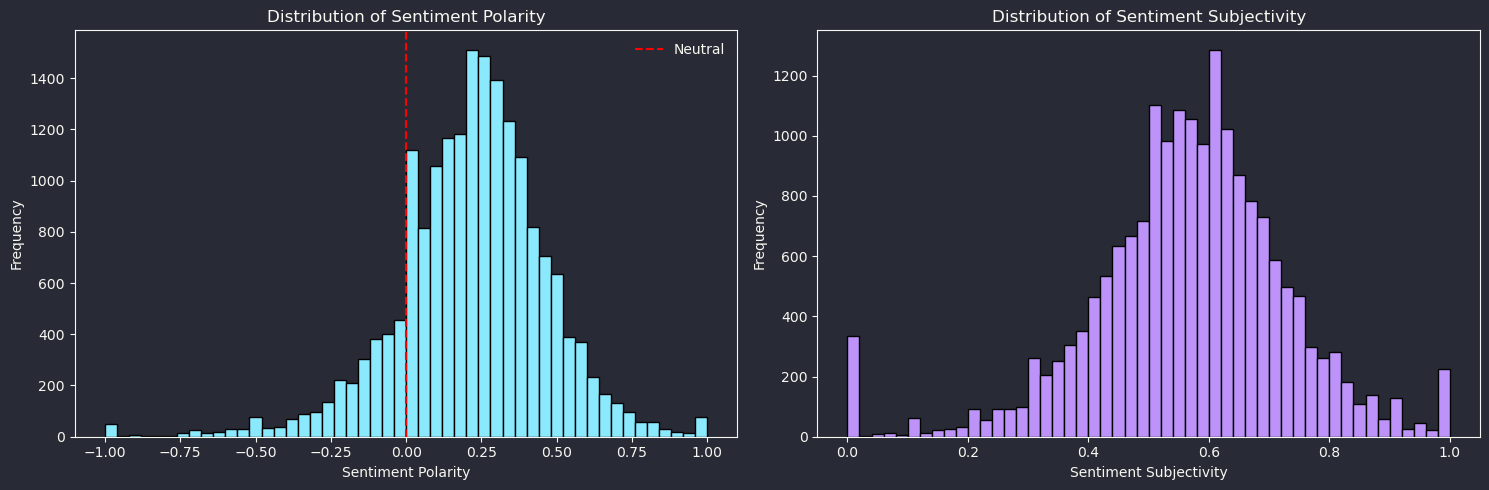

In [14]:
plt.style.use(matplotx.styles.dracula)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Polarity
axes[0].hist(df_unique['sentiment_polarity'], bins=50, color = '#8be9fd', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', label='Neutral')
axes[0].set_xlabel('Sentiment Polarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Sentiment Polarity')
axes[0].legend()

axes[1].hist(df_unique['sentiment_subjectivity'], bins=50, color='#bd93f9', edgecolor='black')
axes[1].set_xlabel('Sentiment Subjectivity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Sentiment Subjectivity')

plt.tight_layout()
plt.show()

The average sentiment polarity of 0.217 indicates that Sephora reviews are moderately positive overall. However, we can notice the polarity range from -1 (extremely negative) to +1(extremely positive). We can notice that 0.217 is just slight shift from the neutral to positive review. And we also can explain it by typical customer behavior, where buyers are selective about what they purchase and more likely to leave reviews for products they have opinions about (strong positive or negative). 

We can observe the normal or near-normal, slightly right-skewed distribution on both histogram plots. The broad distribution reflects that Sephora carries thousands of products with varying quality, price points, and suitability for different skin types—customers express nuanced opinions. There's no single dominant sentiment because reviews are spread across the spectrum rather than clustered at +1.0 or -1.0. Taking precisely into consideration subjectivity plot, we can see that reviews are slightly more opinion-based than fact-based. So, it means that customers use evaluative language ("amazing," "terrible," "works for me") rather than pure description (like "containing aroma, glycerin", ect.). This again supports "healthy" behavior regarding products reviews, where customers share personal experiences and judgments. 

## EDA
### Text statistics

In [53]:
# Calculate various text statistics from review text
def calculate_text_stats(text):
    if pd.isna(text) or text == "":
        return 0, 0, 0, 0, 0
    
    # Tokenize and filter to alphabetic words only
    all_tokens = word_tokenize(str(text))
    words = [w for w in all_tokens if w.isalpha()]
    sentences = sent_tokenize(str(text))
    
    return (
        len(words),
        len(text),
        len(sentences),
        np.mean([len(word) for word in words]) if words else 0,
        len(set(words))
    )

print("Calculating text statistics...")
text_stats = df_unique['full_review'].apply(calculate_text_stats)

df_unique['word_count'] = text_stats.apply(lambda x: x[0])
df_unique['char_count'] = text_stats.apply(lambda x: x[1])
df_unique['sentence_count'] = text_stats.apply(lambda x: x[2])
df_unique['avg_word_length'] = text_stats.apply(lambda x: x[3])
df_unique['unique_words'] = text_stats.apply(lambda x: x[4])

print("\nText Statistics Summary:")
print(df_unique[['word_count', 'char_count', 'sentence_count', 'avg_word_length', 'unique_words']].describe())

Calculating text statistics...

Text Statistics Summary:
         word_count    char_count  sentence_count  avg_word_length  \
count  18556.000000  18556.000000    18556.000000     18556.000000   
mean      55.108321    296.882302        4.224617         4.181720   
std       41.348956    230.427676        2.610282         0.460577   
min        1.000000     38.000000        1.000000         2.000000   
25%       30.000000    161.000000        3.000000         3.893939   
50%       45.000000    237.000000        4.000000         4.139535   
75%       65.000000    344.000000        5.000000         4.418605   
max      396.000000   2048.000000       29.000000        24.500000   

       unique_words  
count  18556.000000  
mean      42.455109  
std       25.307152  
min        1.000000  
25%       26.000000  
50%       37.000000  
75%       50.000000  
max      217.000000  


The Sephora review corpus comprises 18,556 unique reviews with a mean length of 55 words (SD = 41.3), organized into an average of 4.2 sentences. Reviews exhibit high lexical diversity (77% unique words per review), indicating authentic, user-generated content. The average word length of 4.18 characters suggests accessible, everyday language rather than technical terminology. The distribution is right-skewed, with most reviews ranging from 30-65 words, though some highly engaged customers submit detailed 300+ word assessments. We can notice that these characteristics are also consistent with mobile e-commerce review.

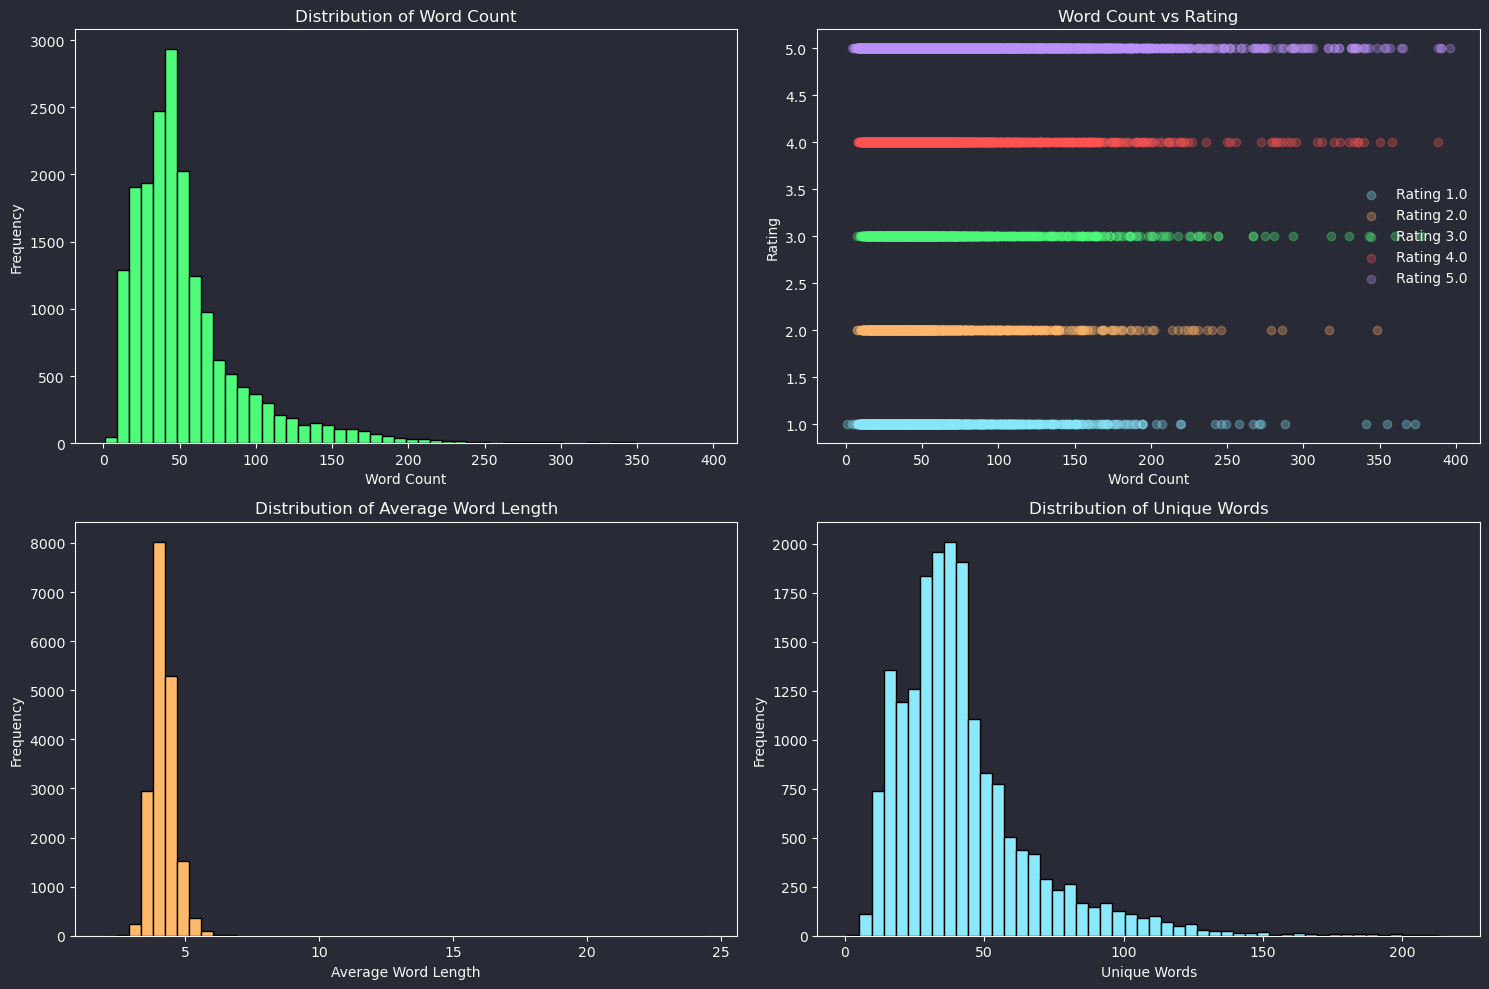

In [58]:
plt.style.use(matplotx.styles.dracula)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(df_unique['word_count'], bins=50, color='#50fa7b', edgecolor='black')
axes[0, 0].set_xlabel('Word Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Word Count')

for rating in sorted(df_unique['rating_value'].unique()):
    subset = df_unique[df_unique['rating_value'] == rating]
    axes[0, 1].scatter(subset['word_count'], subset['rating_value'], alpha=0.3, label=f'Rating {rating}')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Rating')
axes[0, 1].set_title('Word Count vs Rating')
axes[0, 1].legend()

axes[1, 0].hist(df_unique['avg_word_length'], bins=50, color='#ffb86c', edgecolor='black')
axes[1, 0].set_xlabel('Average Word Length')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Average Word Length')

axes[1, 1].hist(df_unique['unique_words'], bins=50, color='#8be9fd', edgecolor='black')
axes[1, 1].set_xlabel('Unique Words')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Unique Words')

plt.tight_layout()
plt.show()

The Word count distribution (top left) histogram is right‑skewed.  Most reviews fall between roughly 20 and 80 words, with a long tail up to nearly 400 words. This confirms that the typical review is concise (a short paragraph), while a minority of users write very long, detailed reviews, which pull the mean above the median. <br>

​
Word count vs rating (top right) plot shows that ratings are clearly discrete at 1–5, and for each rating there is a wide spread of word counts, mostly between about 20 and 150 words. There is no strong visual pattern that higher ratings are systematically longer or shorter. Very short and very long reviews exist at all rating levels, which suggests that review length alone is not a strong driver of rating.<br>

Average word length distribution (bottom left) displays that average word length is tightly concentrated around 4–4.5 characters, with almost all reviews in a narrow band from about 3.5 to 5. This again indicates that reviewers use simple, everyday vocabulary, which is good for readability and suggests the text is accessible and not overly technical.<br>

Unique words distribution (bottom right) per review peaks around 30–50 and is right‑skewed, extending beyond 150 unique words in a few long reviews. Compared to the total word count distribution, this implies a high proportion of unique tokens per review, so the language is not highly repetitive and the corpus offers good lexical diversity. <br>

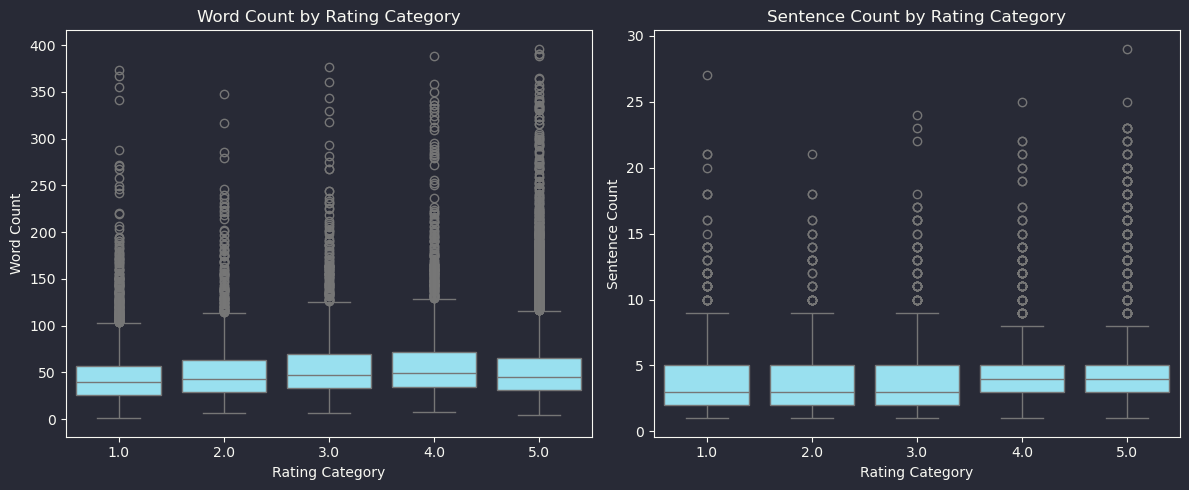

             word_count                                                      \
                  count       mean        std  min   25%   50%   75%    max   
rating_value                                                                  
1.0              2705.0  48.173013  35.732327  1.0  26.0  40.0  57.0  373.0   
2.0              1471.0  52.733515  38.229005  7.0  29.0  43.0  63.0  348.0   
3.0              1506.0  59.061753  43.427729  7.0  33.0  47.0  70.0  377.0   
4.0              2328.0  60.505584  44.988916  8.0  34.0  49.0  72.0  388.0   
5.0             10546.0  55.462450  41.708457  4.0  31.0  45.0  65.0  396.0   

             sentence_count                                                
                      count      mean       std  min  25%  50%  75%   max  
rating_value                                                               
1.0                  2705.0  3.797043  2.396340  1.0  2.0  3.0  5.0  27.0  
2.0                  1471.0  3.766825  2.348979  1.0  2.0  3.0 

In [60]:
# Length vs rating / sentiment
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_unique, x='rating_value', y='word_count', color='#8be9fd')
plt.title('Word Count by Rating Category')
plt.xlabel('Rating Category')
plt.ylabel('Word Count')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_unique, x='rating_value', y='sentence_count', color='#8be9fd')
plt.title('Sentence Count by Rating Category')
plt.xlabel('Rating Category')
plt.ylabel('Sentence Count')

plt.tight_layout()
plt.show()

print(df_unique.groupby('rating_value')[['word_count', 'sentence_count']].describe())

The boxplots show that review length (in words and sentences) increases slightly with higher ratings, but the effect is modest and there is substantial overlap across all rating categories. Median word count rises from around 40–45 words for 1–2 star reviews to about 55–60 words for 4–5 star reviews, indicating that more satisfied customers tend to write somewhat longer reviews. However, the interquartile ranges overlap heavily, and all rating groups have many outliers extending above 150–200 words, so very long and very short reviews appear at every rating level. Median sentence count increases from roughly 2–3 sentences for low ratings to about 4–5 sentences for high ratings, again suggesting that higher ratings are associated with slightly more elaborated narratives.

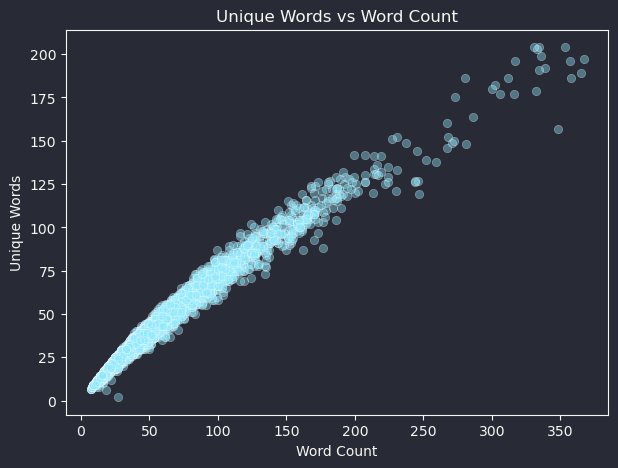


Correlation (Word_Count vs Unique_Words): 0.984


In [62]:
# Vocabulary size vs review length

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_unique.sample(min(5000, len(df_unique)), random_state=42),
                x='word_count', y='unique_words', alpha=0.4, color='#8be9fd')
plt.title('Unique Words vs Word Count')
plt.xlabel('Word Count')
plt.ylabel('Unique Words')
plt.show()

# print correlation
corr_vocab_len = df_unique['word_count'].corr(df_unique['unique_words'])
print(f"\nCorrelation (Word_Count vs Unique_Words): {corr_vocab_len:.3f}")

This plot shows a strong, almost linear relationship between review length and lexical diversity: as reviews get longer, they introduce more unique words, but with gradually decreasing marginal gains. For short reviews (up to 50 words), the number of unique words rises almost one‑to‑one with word count, implying very little repetition and highly compact messages. Beyond 100–150 words, the curve starts to flatten slightly, meaning additional length comes with more repeated words, but even at 300+ words reviews still contain well over 150 unique tokens, indicating high vocabulary richness and  authentic human writing in this corpus.

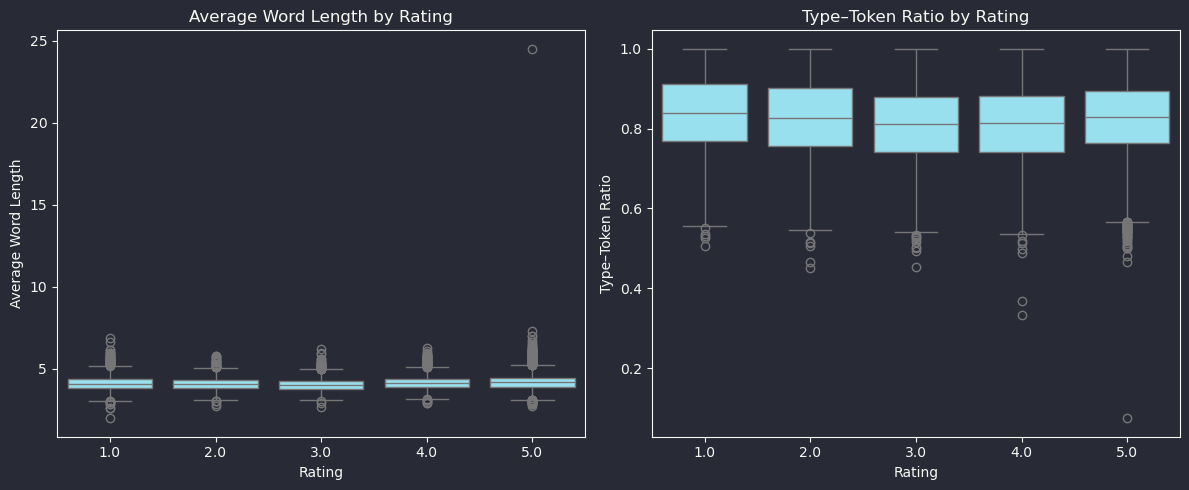


Readability/style by rating (group means):
              avg_word_length  Type_Token_Ratio
rating_value                                   
1.0                  4.145734          0.837263
2.0                  4.098953          0.823956
3.0                  4.056437          0.807156
4.0                  4.161627          0.811335
5.0                  4.224821          0.827473


In [ ]:
# Readability / style proxies

# Type–token ratio
df_unique['type_token_ratio'] = df_unique['unique_words'] / df_unique['word_count'].replace(0, np.nan)

plt.style.use(matplotx.styles.dracula)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_unique, x='rating_value', y='avg_word_length', color='#8be9fd')
plt.title('Average Word Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Word Length')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_unique, x='rating_value', y='type_token_ratio', color='#8be9fd')
plt.title('Type–Token Ratio by Rating')
plt.xlabel('Rating')
plt.ylabel('Type–Token Ratio')

plt.tight_layout()
plt.show()

print("\nReadability/style by rating (group means):")
print(df_unique.groupby('rating_value')[['avg_word_length', 'type_token_ratio']].mean())

These results suggest that writing style is broadly similar across ratings, with only subtle differences in complexity and lexical variety. Mean average word length ranges narrowly from about 4.06 to 4.22 characters, with 3‑star reviews using slightly shorter words and 5‑star reviews slightly longer ones. Type-token ratio (TTR) values are high overall (around 0.80–0.84), indicating rich vocabulary and low repetition in reviews at every rating level. 1‑star and 5‑star reviews show slightly higher TTR than mid‑range ratings, which suggests that very satisfied or very dissatisfied customers tend to use a bit more varied language when describing their experiences, while neutral/mixed reviews are marginally more repetitive.

Overall, EDA shows that average sentiment polarity increases sharply between 3 and 4 stars, while the difference between 1–2–3 is smaller compared to the 3–4 and 4–5 jumps. This suggests that the main semantic boundary in the data lies between 3 and 4 stars. In the light of this findings, using 4–5 as positive and 1–3 as negative categories matches the binary label, that we applied above,  with the underlying sentiment structure of the corpus.

### Other variables statistics

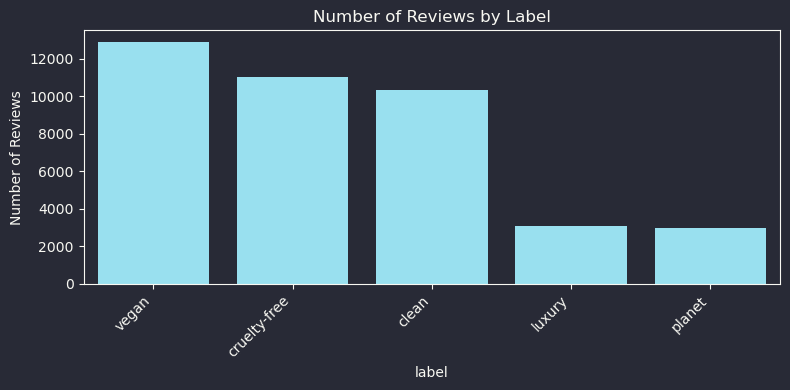

In [ ]:
# Check labels 
# Basic distribution of labels
label_counts = df['label'].value_counts(normalize=False)
label_prop   = df['label'].value_counts(normalize=True)

# Average rating and price by label
label_stats = df.groupby('label').agg(
    n_reviews      = ('review_id', 'count'),
    n_products     = ('name', 'nunique'),
    avg_rating     = ('rating_value', 'mean'),
    avg_agg_rating = ('aggregate_rating', 'mean'),
    avg_price      = ('price', 'mean')
).sort_values('n_reviews', ascending=False)

plt.figure(figsize=(8, 4))
label_counts = df['label'].value_counts().sort_values(ascending=False)

sns.barplot(x=label_counts.index, y=label_counts.values, color='#8be9fd')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews by Label')
plt.tight_layout()
plt.show()

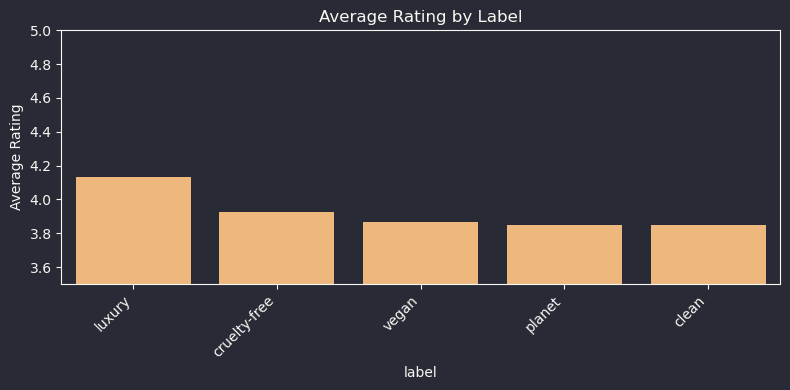

In [19]:
plt.figure(figsize=(8, 4))
label_rating = df.groupby('label')['rating_value'].mean().sort_values(ascending=False)

sns.barplot(x=label_rating.index, y=label_rating.values, color='#ffb86c')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Rating')
plt.ylim(3.5, 5.0)
plt.title('Average Rating by Label')
plt.tight_layout()
plt.show()

Vegan, cruelty‑free, and clean products account for the large part of reviews, each with around 10k–13k observations, while luxury and planet labels are much smaller segments. This suggests that the dataset is primarily capturing mainstream “ethical/clean beauty” positioning, and inferences about luxury or planet products should be made cautiously due to lower sample size. Regarding the rating, all labels have fairly similar average ratings in the high‑3s to low‑4s range, indicating that customers are generally satisfied regardless of marketing label. Luxury products show a noticeably higher mean rating (around 4.1–4.2) than the other labels (around 3.85–3.9), which may reflect higher perceived performance, stronger brand expectations, or selection effects (fewer but more premium, well‑reviewed items).

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40234 entries, 0 to 40233
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         40234 non-null  int64  
 1   date_published    40234 non-null  object 
 2   rating_value      40234 non-null  float64
 3   label             40234 non-null  object 
 4   name              40234 non-null  object 
 5   brand             40234 non-null  object 
 6   category          40234 non-null  object 
 7   description       40234 non-null  object 
 8   price             40234 non-null  float64
 9   currency          40234 non-null  object 
 10  review_count      40234 non-null  float64
 11  aggregate_rating  40234 non-null  float64
 12  full_review       40234 non-null  object 
 13  rating_binary     40234 non-null  int64  
 14  rating_category   40234 non-null  object 
dtypes: float64(4), int64(2), object(9)
memory usage: 4.6+ MB


data analysis of other variables <br>
word clouds
clustering (bag of words)!!! <br> (check class materials 4, 5, 7)

modeling <br>
evaluation (quality of obtained results) <br>
summary <br>
was the purpose achived? <br>
were the assumptions examined <br>
fromulate conclusions from the obtained result <br>
appendix with source code and  data set 

## Resources 
1. Data source [https://www.kaggle.com/datasets/natashamessier/sephora-skincare-reviews-and-sentiment] 
2. Class material 
3. https://www.geeksforgeeks.org/python/introduction-to-emoji-module-in-python/
4. https://www.sketchengine.eu/glossary/type-token-ratio-ttr/